In [6]:
!pip install pytorch

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build pytorch


  error: subprocess-exited-with-error
  
  × Building wheel for pytorch (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [20 lines of output]
      Traceback (most recent call last):
        File "C:\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
          main()
        File "C:\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 251, in build_wheel
          return _build_backend().build_wheel(wheel_directory, config_settings,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\DELL\AppData\Local\Temp\pip-build-env-mlw63lg6\overlay\Lib\site-packages\setuptools\build_meta.py", l

In [2]:
import os
import copy
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
from torchvision import models
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.font_manager
from collections import OrderedDict

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

import os
print(os.getcwd())

d:\Learning\DATN\project_ai


In [4]:
# Define the path to the classes.txt file
classes_file_path = "classes.txt"

# Check if the classes.txt file exists
if os.path.exists(classes_file_path):
    # Read the content of classes.txt and split it into lines
    with open(classes_file_path, 'r') as file:
        classes = file.read().splitlines()
else:
    print("Error: classes.txt file not found!")

In [5]:
class Label_encoder:
    def __init__(self, labels):
        labels = list(set(labels))
        self.labels = {label: idx for idx, label in enumerate(classes)}

    def get_label(self, idx):
        return list(self.labels.keys())[idx]

    def get_idx(self, label):
        return self.labels[label]

encoder = Label_encoder(classes)
for i in range(20):
    print(encoder.get_label(i), encoder.get_idx( encoder.get_label(i) ))

apple_pie 0
baby_back_ribs 1
baklava 2
beef_carpaccio 3
beef_tartare 4
beet_salad 5
beignets 6
bibimbap 7
bread_pudding 8
breakfast_burrito 9
bruschetta 10
caesar_salad 11
cannoli 12
caprese_salad 13
carrot_cake 14
ceviche 15
cheesecake 16
cheese_plate 17
chicken_curry 18
chicken_quesadilla 19


In [6]:
model = models.densenet201(weights=models.DenseNet201_Weights.DEFAULT)
model = model.to(device)

In [7]:
import torch
from PIL import Image
from torchvision import transforms

def classify_image(image_path, model, label_encoder, device):
    # Load and preprocess the input image
    image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    # Perform prediction
    with torch.no_grad():
        model.eval()
        output = model(image_tensor)

    # Get predicted class index
    _, predicted_idx = torch.max(output, 1)
    predicted_idx = predicted_idx.item()

    # Map index to class name
    predicted_label = label_encoder.get_label(predicted_idx)

    return predicted_label

# Load the saved model and label encoder
model_path = "solution.pth"
model = models.densenet201(weights=None)
classifier = nn.Sequential(
    nn.Linear(1920, 1024),
    nn.LeakyReLU(),
    nn.Linear(1024, len(classes)),
)
model.classifier = classifier
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

label_encoder = Label_encoder(classes)

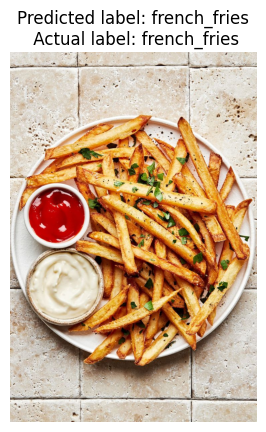

In [16]:
import matplotlib.pyplot as plt
from PIL import Image


# Function to display an image
def display_image(image_path, predicted_label):
    img = Image.open(image_path)
    plt.title(f"Predicted label: {predicted_label}\n Actual label: {image_path.split('/')[-1].split('.')[0]}")
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Example usage
image_path = "./Food/french_fries.jpeg"  # Replace with your image path
predicted_label = classify_image(image_path, model, label_encoder, device)
display_image(image_path, predicted_label)

In [17]:
import random
# Function to preprocess image
def preprocess_image(image):
    resized_image = image.resize((256, 256))
    cropped_image = transforms.CenterCrop(224)(resized_image)
    tensor_image = transforms.ToTensor()(cropped_image)
    normalized_image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(tensor_image)
    preprocessed_image = normalized_image.unsqueeze(0)
    return preprocessed_image

# Function to get random images from a directory
def get_random_images(image_dir, num_images=20):
    image_files = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(('jpg', 'jpeg', 'png'))]
    random_images = random.sample(image_files, num_images)
    return random_images

# Function to predict image
def predict_image(image_path):
    image = Image.open(image_path)
    preprocessed_image = preprocess_image(image)
    with torch.no_grad():
        output = model(preprocessed_image.to(device))
    _, predicted_idx = torch.max(output, 1)
    predicted_idx = predicted_idx.item()
    predicted_prob = torch.softmax(output, dim=1)[0, predicted_idx].item()
    predicted_label = encoder.get_label(predicted_idx)
    return predicted_label, predicted_prob

In [28]:
def prep_df(path: str) -> pd.DataFrame:
    array = open(path, 'r').read().splitlines()

    # Getting the full path for the images
    img_path = "./images/"
    full_path = [img_path + img + ".jpg" for img in array]

    # Splitting the image index from the label
    imgs = []
    for img in array:
        img = img.split('/')

        imgs.append(img)

    imgs = np.array(imgs)
    # Converting the array to a data frame
    imgs = pd.DataFrame(imgs[:,0], imgs[:,1], columns=['label'])
    # Adding the full path to the data frame
    imgs['path'] = full_path

    # Randomly shuffling the order to the data in the dataframe
    imgs = shuffle(imgs)

    return imgs

In [29]:
train_imgs = prep_df('./meta/train.txt')
test_imgs = prep_df('./meta/test.txt')

train_imgs.head(5)

label                                path
2349384  chicken_wings  ./images/chicken_wings/2349384.jpg
3606817      escargots      ./images/escargots/3606817.jpg
2610785       takoyaki       ./images/takoyaki/2610785.jpg
1655994        mussels        ./images/mussels/1655994.jpg
2292954        churros        ./images/churros/2292954.jpg

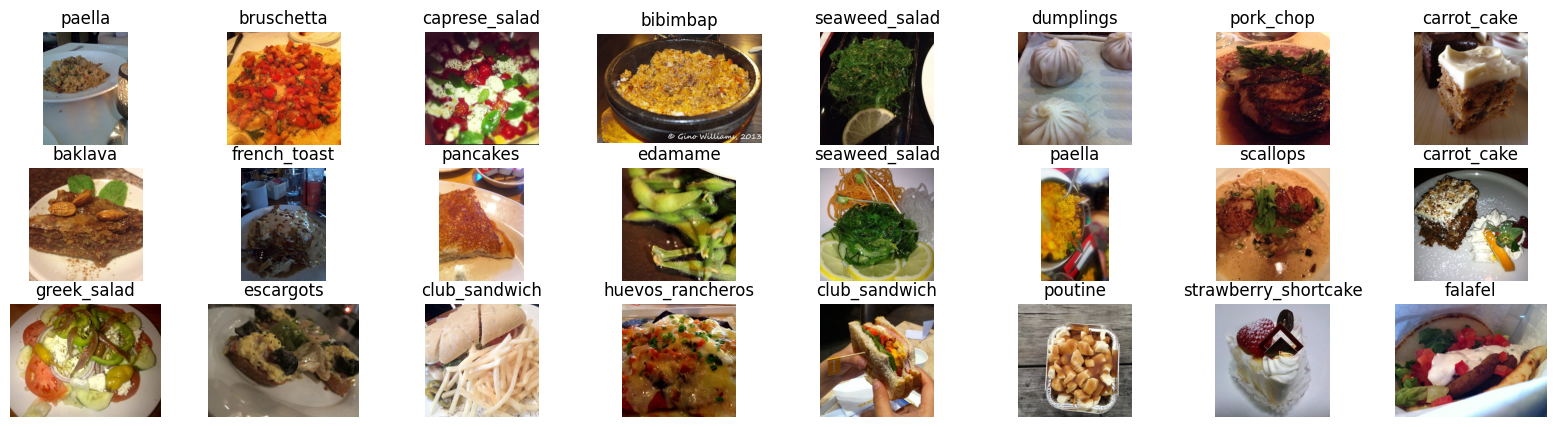

In [30]:
plt.figure(figsize=(20, 5))

num_rows = 3
num_cols = 8


for idx in range(num_rows * num_cols):
    random_idx = np.random.randint(0, train_imgs.shape[0])
    img = plt.imread(train_imgs.path.iloc[random_idx])

    label = train_imgs.label.iloc[random_idx]

    ax = plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

d:\Learning\DATN\project_ai\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Learning\DATN\project_ai\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


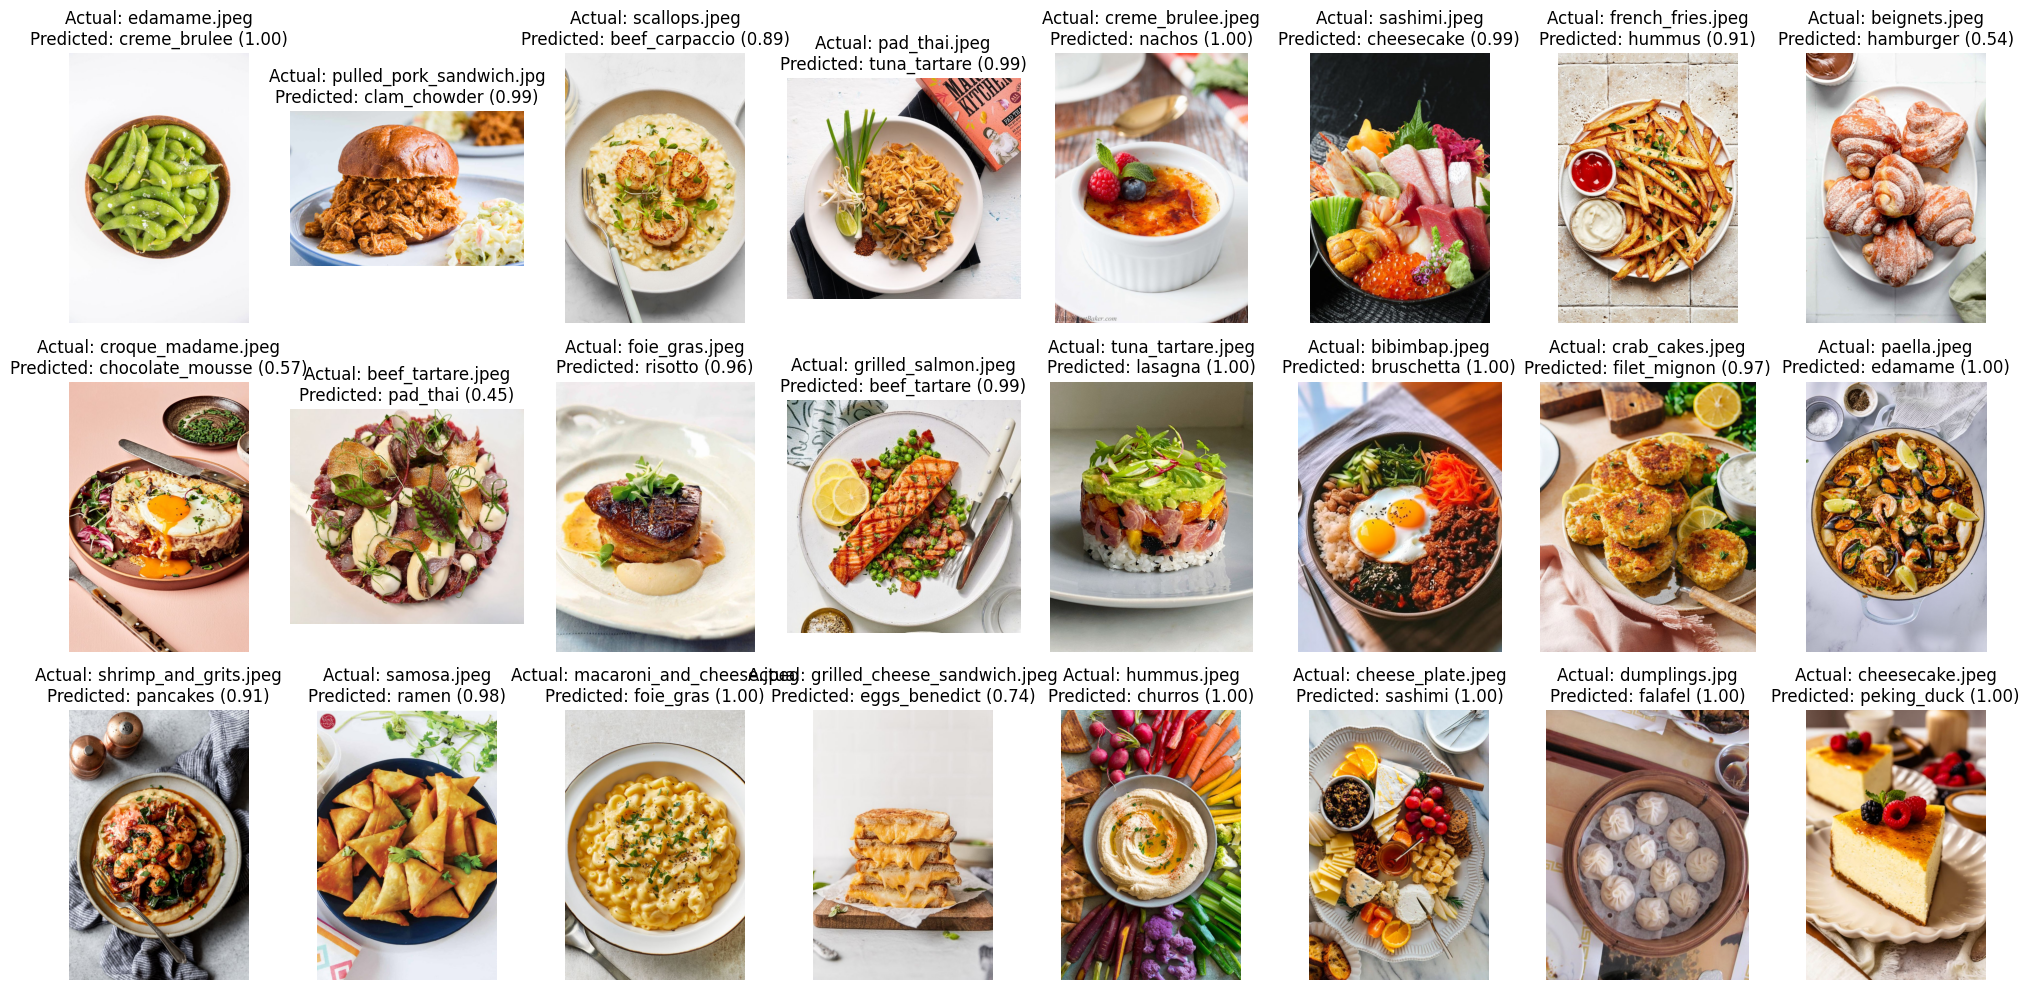

In [64]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms, models
import torch.nn as nn

# Define the path to the classes.txt file
classes_file_path = "classes.txt"

# Load classes
if os.path.exists(classes_file_path):
    with open(classes_file_path, 'r') as file:
        classes = file.read().splitlines()
else:
    raise FileNotFoundError("Error: classes.txt file not found!")

# Define the path to the model file
model_path = "solution.pth"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the Label_encoder class
class Label_encoder:
    def __init__(self, labels):
        labels = list(set(labels))
        self.labels = {label: idx for idx, label in enumerate(labels)}

    def get_label(self, idx):
        return list(self.labels.keys())[idx]

    def get_idx(self, label):
        return self.labels[label]

encoder = Label_encoder(classes)

# Load the model
model = models.densenet201(pretrained=True)
model.classifier = nn.Sequential(
  nn.Linear(1920, 1024),
  nn.LeakyReLU(),
  nn.Linear(1024, len(classes)),
)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Function to preprocess image
def preprocess_image(image):
    resized_image = image.resize((256, 256))
    cropped_image = transforms.CenterCrop(224)(resized_image)
    tensor_image = transforms.ToTensor()(cropped_image)
    normalized_image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(tensor_image)
    preprocessed_image = normalized_image.unsqueeze(0)
    return preprocessed_image

# Function to predict image
def predict_image(image_path):
    image = Image.open(image_path)
    preprocessed_image = preprocess_image(image)
    with torch.no_grad():
        output = model(preprocessed_image.to(device))
    _, predicted_idx = torch.max(output, 1)
    predicted_idx = predicted_idx.item()
    predicted_prob = torch.softmax(output, dim=1)[0, predicted_idx].item()
    predicted_label = encoder.get_label(predicted_idx)
    return predicted_label, predicted_prob

# Function to get all images from a directory
def get_all_images(image_dir):
    image_files = []
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                image_path = os.path.join(root, file)
                image_files.append((image_path, file))  # Append tuple of (absolute path, filename)
    return image_files

# Get all images from the 'Food' directory
image_dir = r'D:\Learning\DATN\project_ai\Food'
image_files = get_all_images(image_dir)

# Display random images with actual and predicted labels
plt.figure(figsize=(20, 10))

num_rows = 3
num_cols = 8

for idx, (img_path, img_name) in enumerate(random.sample(image_files, num_rows * num_cols)):
    img = plt.imread(img_path)
    actual_label = os.path.basename(os.path.dirname(img_path))  # Get the folder name as the actual label
    predicted_label, prob = predict_image(img_path)

    ax = plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(img)
    plt.title(f"Actual: {img_name}\nPredicted: {predicted_label} ({prob:.2f})")
    plt.axis("off")

plt.tight_layout()
plt.show()


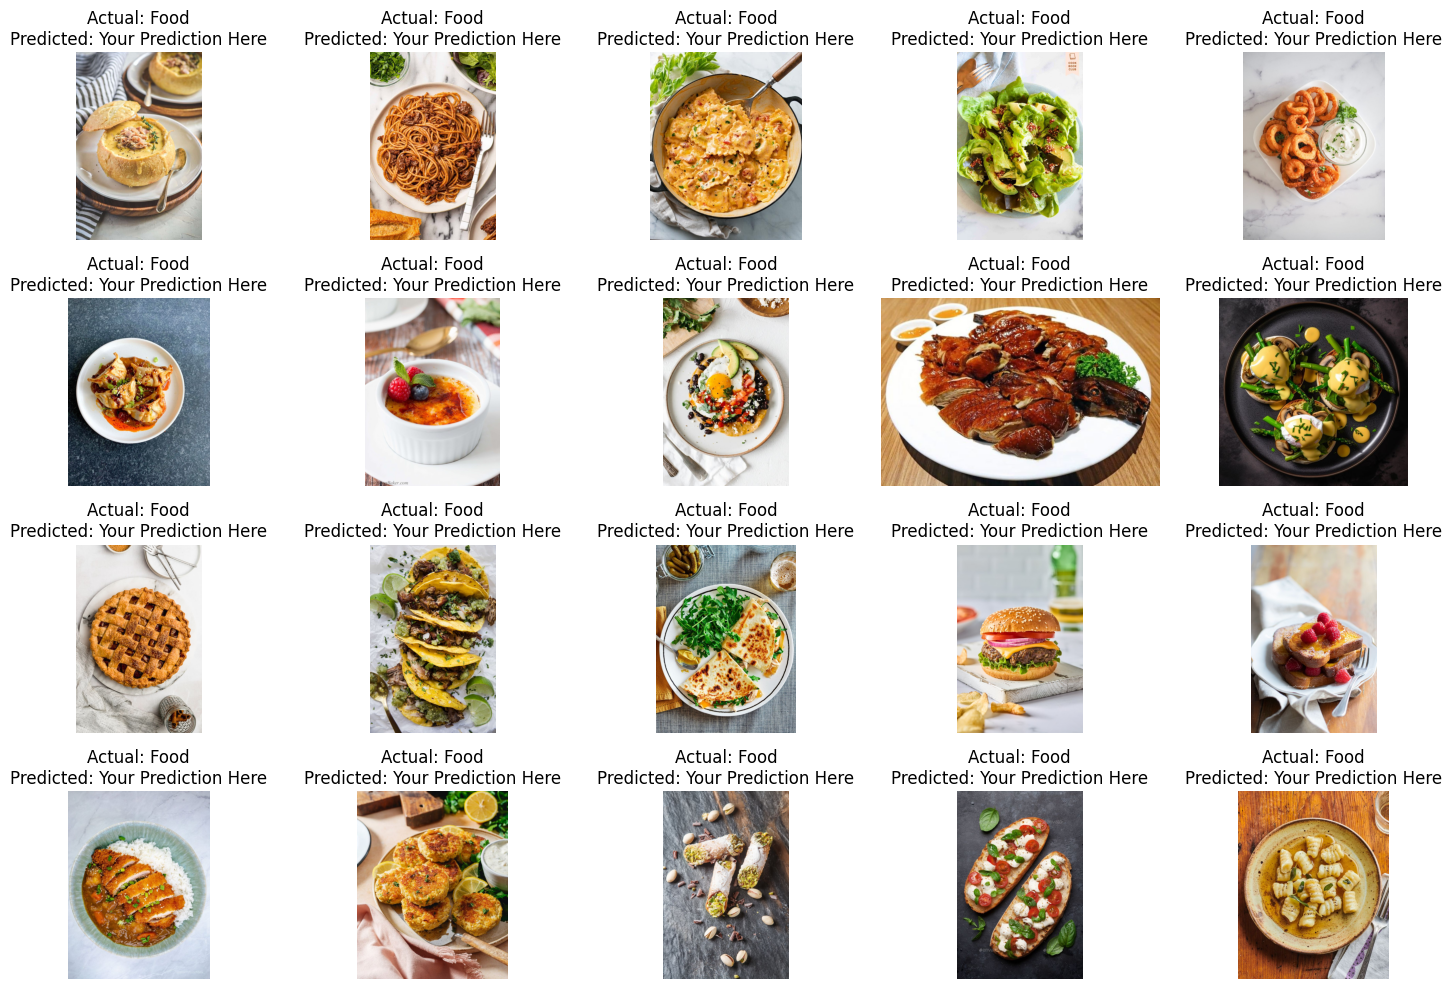

In [47]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Đường dẫn tới thư mục chứa các ảnh
folder_path = r'D:\Learning\DATN\project_ai\Food'

# Lấy danh sách các tệp tin ảnh
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(('.jpg', '.jpeg', '.png'))]

# Chọn ngẫu nhiên 20 ảnh từ danh sách
random_images = random.sample(image_files, 20)

# Hiển thị từng ảnh và dự đoán
plt.figure(figsize=(15, 10))
for i, img_path in enumerate(random_images):
    img = Image.open(img_path)
    plt.subplot(4, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')

    # Lấy nhãn thực tế từ tên thư mục chứa ảnh
    actual_label = os.path.basename(os.path.dirname(img_path))

    # Dự đoán nhãn sử dụng mô hình ở đây và hiển thị kết quả
    predicted_label = "Your Prediction Here"  # Thay bằng mã dự đoán thực tế của bạn

    plt.title(f'Actual: {actual_label}\nPredicted: {predicted_label}')

plt.tight_layout()
plt.show()


In [44]:
from flask import Flask, request, render_template
from PIL import Image
import torch
from torchvision import transforms

app = Flask(__name__)

# Load the saved model and label encoder
model_path = "solution.pth"
model = models.densenet201(weights=None)
classifier = nn.Sequential(
  nn.Linear(1920, 1024),
  nn.LeakyReLU(),
  nn.Linear(1024, 101),
)
model.classifier = classifier
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

label_encoder = Label_encoder(classes)

# Define the route for the home page
@app.route('/')
def home():
  return render_template('index.html')

# Define the route for image upload and prediction
@app.route('/predict', methods=['POST'])
def predict():
  # Get the uploaded image file
  image_file = request.files['image']

  # Read and preprocess the image
  image = Image.open(image_file)
  preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
  image_tensor = preprocess(image).unsqueeze(0).to(device)

  # Perform prediction
  with torch.no_grad():
    model.eval()
    output = model(image_tensor)

  # Get predicted class index
  _, predicted_idx = torch.max(output, 1)
  predicted_idx = predicted_idx.item()

  # Map index to class name
  predicted_label = label_encoder.get_label(predicted_idx)

  return render_template('result.html', predicted_label=predicted_label)

if __name__ == '__main__':
  app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


In [13]:
!pip install torchviz

In [15]:
from torchviz import make_dot
x = torch.randn(1, 3, 224, 224).to(device)

# Truyền tensor qua mô hình để tạo biểu đồ
y = model(x)
dot = make_dot(y, params=dict(model.named_parameters()))

# Lưu biểu đồ thành file ảnh
dot.format = 'png'
dot.render('densenet201_model')

ModuleNotFoundError: No module named 'torchviz'